<a href="https://colab.research.google.com/github/dijanaperovic/Predikcija-kategorije-proizvoda-na-osnovu-naslova/blob/main/predikcija_kategorije_proizvoda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Istrazivanje samog dataset-a

Veličina dataset-a:  (35311, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB
Informacije:  None

Broj Na vrednosti po kolonama: 
product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64

Raspodela proizvoda po kategorijama: 
 Category Label
Fridge Freezers     5495
Washing M

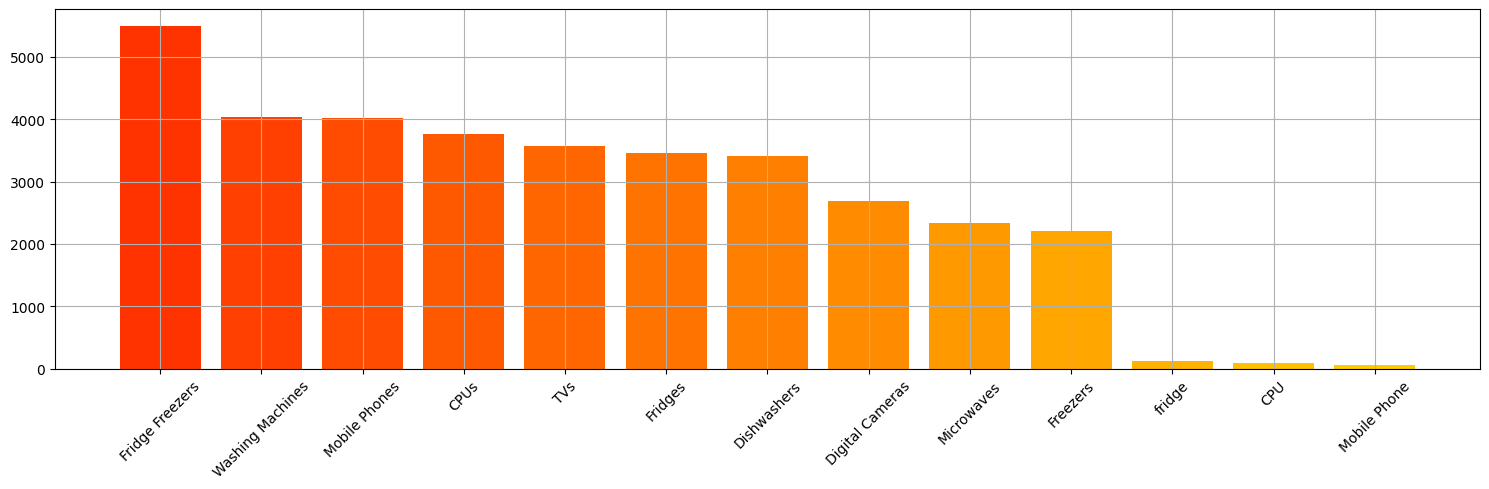

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://raw.githubusercontent.com/dijanaperovic/Predikcija-kategorije-proizvoda-na-osnovu-naslova/refs/heads/main/data/products.csv"
df = pd.read_csv(url)
print("Veličina dataset-a: ", df.shape)
print("Informacije: ", df.info())
print("\nBroj Na vrednosti po kolonama: ")
print(df.isna().sum())

category_counts = df[' Category Label'].value_counts()
print("\nRaspodela proizvoda po kategorijama: ")
print(category_counts)

plt.figure(figsize=(15,5))
colors = plt.cm.autumn(np.linspace(0.2, 0.8, len(category_counts)))
plt.bar(category_counts.index, category_counts.values, color = colors)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df = df.dropna()
print(df.shape)
print(df.isna().sum())
#Standardizovanje naziva kolona za lepši prikaz i lakše snalaženje
df.columns = df.columns.str.lower().str.strip().str.replace(r' ', '_', regex = True)
print(df.columns.to_list())

(34760, 8)
product_id         0
product_title      0
merchant_id        0
category_label     0
_product_code      0
number_of_views    0
merchant_rating    0
listing_date       0
dtype: int64
['product_id', 'product_title', 'merchant_id', 'category_label', '_product_code', 'number_of_views', 'merchant_rating', 'listing_date']
